# Estimated Total Pumping Volume for Wells


In [6]:
import pandas as pd
import numpy as np
from pathlib import Path
import geopandas as gpd
from scipy import stats
import matplotlib.pyplot as plt
import scipy.stats as stats

import sys
sys.path.append('src')
import well_pump 



In [7]:
raw_fold_drive = "G"

if sys.platform == 'darwin':
    print('mac')
    raw_fold = Path('/users/ink/Google Drive/My Drive/')
else:
    print('pc')
    raw_fold = Path(f'{raw_fold_drive}:/My Drive/')
planet_fold = raw_fold / 'Planet'


mac


# Examine Well Data

In [8]:

fields = pd.read_csv("output_tables/fields_by_groupnumber_v2.csv")
fields.columns
fields['pump_est_2024'] = fields['efet_2024']/0.70


well = pd.read_csv("output_tables/wells_with_properties.csv")
well = well[well['USES']=='I']
wells_w_field_info = pd.merge(well, fields, left_on='GROUP_NUMB', right_on='GROUP_NUMB')
wells_w_field_info.sort_values("GROUP_NUMB")
nowellsperfield = wells_w_field_info.groupby('GROUP_NUMB').size().to_dict()
wells_w_field_info['num_wells_per_field'] = wells_w_field_info['GROUP_NUMB'].map(nowellsperfield)
wells_w_field_info.drop(columns=['qtywtr',
                                 'AbandonDate',
                                 'proof_flow_gpm',
                                 'NewWellDate',
                                 'CFS','ACFT',
                                 'PRIORITY',
                                 'SUMMARY_ST',
                                 'FlowSource',
                                 ],inplace=True)
for col in wells_w_field_info.columns:
    if "efet" in col or "consump" in col or "precip" in col or "et_" in col:
        if "2024" in col:
           pass
        else:
            wells_w_field_info.drop(columns=[col],inplace=True) 


def estimate_gpm(x, mult=8):
    if pd.isna(x[0]) or x[0]<=0:
        return x[1] * mult
    else:
        return x[0]

wells_w_field_info['GPM'] = wells_w_field_info[['GPM','horsepower']].apply(lambda x: estimate_gpm(x), axis=1)
wells_w_field_info['est_pump_acreft'] = wells_w_field_info['GPM']*60*24*wells_w_field_info['watering_days'] * 3.06889e-6
wells_w_field_info['max_pump_acreft'] = wells_w_field_info['GPM']*60*24*213 * 3.06889e-6
wells_w_field_info.to_clipboard()



/var/folders/jg/b66w1nm54nj99vk_9vx8vntr0000gn/T/ipykernel_48631/1642685164.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.isna(x[0]) or x[0]<=0:
/var/folders/jg/b66w1nm54nj99vk_9vx8vntr0000gn/T/ipykernel_48631/1642685164.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return x[0]
/var/folders/jg/b66w1nm54nj99vk_9vx8vntr0000gn/T/ipykernel_48631/1642685164.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return x

# Bring in Canal Data

In [22]:
res_q = pd.read_csv("output_tables/res_discharge.csv")
res_q['Date'] = pd.to_datetime(res_q['Date'])
res_q.set_index('Date', inplace=True)
res_q['beaver_acft'] = res_q['Flume Discharge (cfs)']*1.98347 # convert cfs to acre-ft/day
res_q = res_q.drop(columns=['Flume Discharge (cfs)','Notes'])

res_q = res_q.resample('D').asfreq().interpolate() # daily frequency with interpolation for data gaps
res_q_monthly = res_q.resample('ME').sum()
res_q_yearly = res_q.resample('YE').sum()
res_q_yearly['year'] = res_q_yearly.index.year
res_q_yearly.set_index('year', inplace=True)
res_q_yearly

beav_q= pd.read_csv("output_tables/beaver_at_rocky_ford_dam.txt",parse_dates={'Date':[0,1,2]},index_col='Date')
beav_q['beaver_acft'] = beav_q['Discharge in CFS']*1.98347
beav_q = beav_q.resample('D').asfreq().interpolate()
beav_q_yearly = beav_q.resample('YE').sum()
beav_q_yearly['year'] = beav_q_yearly.index.year
beav_q_yearly.set_index('year', inplace=True)
beav_q_yearly = beav_q_yearly.drop(columns=['Discharge in CFS'],axis=1).round(0)
beav = pd.concat([beav_q_yearly, res_q_yearly], axis=0).dropna().round(0)#.to_frame()
beav = beav.loc[1914:]

utopia = pd.read_csv("output_tables/utopia.csv",parse_dates=[0],index_col='Date').drop(['Notes'],axis=1)
flat = pd.read_csv("output_tables/flat.csv",parse_dates=[0],index_col='Date').drop(['Notes'],axis=1)
flat['flat_acft'] = flat['Discharge (cfs)']*1.98347
utopia['utopia_acft'] = utopia['Discharge (cfs)']*1.98347
flat = flat.drop(['Discharge (cfs)'],axis=1)
utopia = utopia.drop(['Discharge (cfs)'],axis=1)
all_canals = pd.concat([res_q,flat,utopia],axis=1)
all_canals['minersville_acft'] = all_canals['utopia_acft'] + all_canals['flat_acft']
all_canals['milford_acft'] = all_canals['beaver_acft'] - all_canals['minersville_acft']



/var/folders/jg/b66w1nm54nj99vk_9vx8vntr0000gn/T/ipykernel_48631/573477297.py:14: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  beav_q= pd.read_csv("output_tables/beaver_at_rocky_ford_dam.txt",parse_dates={'Date':[0,1,2]},index_col='Date')


In [21]:
beav

,beaver_acft
year,
1913,514.0
1914,49350.0
1915,34941.0
1916,35463.0
1917,28724.0
...,...
2021,6273.0
2022,5536.0
2023,26195.0


Text(0, 0.5, 'Minersville Dam Release (ac-ft/yr)')

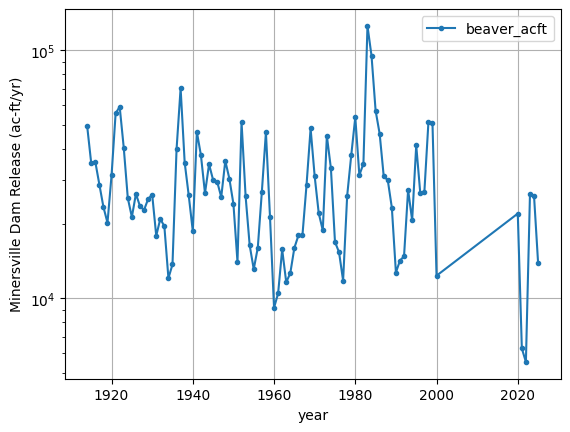

In [24]:
beav.plot(marker=".")
plt.grid()
plt.yscale('log')
plt.ylabel('Minersville Dam Release (ac-ft/yr)')

(-10.0, 500.0)

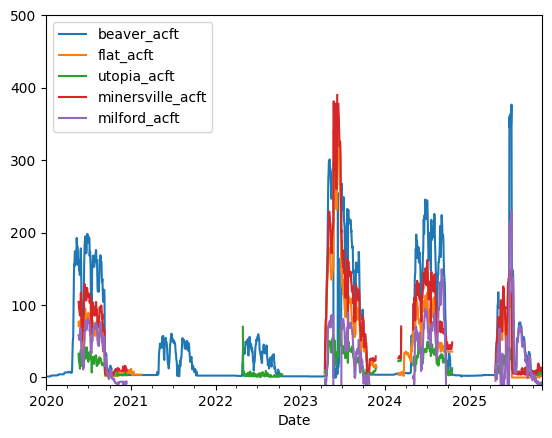

In [26]:
all_canals.plot()
plt.ylim(-10,500)

# Estimate Infilration

Irrigation pumping Estimates from USGS (https://warcapps.usgs.gov/gs-water/uwsc/ugcwa)

In [50]:
usgs_irr = {1990: 41000,
            1991: 47500,
            1992: 35400,
            1993: 44700,        
            1994: 52400,
            1995: 46200,
            1996: 44600,
            1997: 45000,
            1998: 32700,
            1999: 31800,
            2000: 39600,
            2001: 33500,
            2002: 42500,
            2003: 40300,
            2004: 35800,
            2005: 31400,
            2006: 36400,
            2007: 40600,
            2008: 40300,
            2009: 45600,
            2010: 41100,
            2011: 32200,
            2012: 44700,
            2013: 45900,
            2014: 45700,
            2015: 44900,
            2016: 45000,
            2017: 46800,
            2018: 59584,
            2019: 39912,
            2020: 46863,
            2021: 47423,
            2022: 52662,
            2023: 38735,
            }

np.float64(13879.0)

Slope: -0.3141165736966256
Intercept: 51719.12041708747
R-squared: 0.5068251249993715
P-value: 0.013989935045488684
Standard Error: 0.10328589102243693


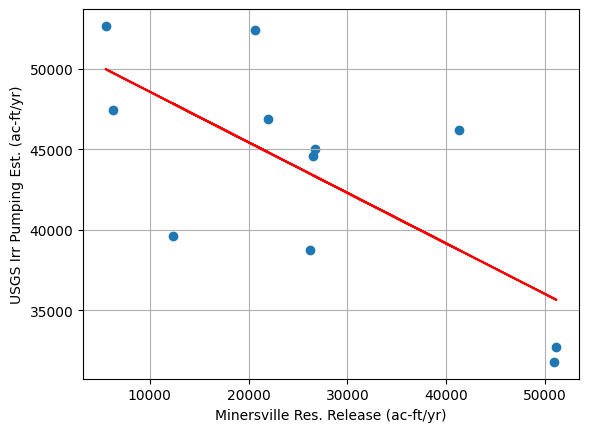

In [42]:
beav_vals = []
usgs_vals = []
for ind in beav.index:
    if ind in usgs_irr.keys():
        beav_vals.append(beav.loc[ind,'beaver_acft'])
        usgs_vals.append(np.float64(usgs_irr[ind]))

beav_vals = np.array(beav_vals)
usgs_vals = np.array(usgs_vals)
slope, intercept, r_value, p_value, std_err = stats.linregress(beav_vals, usgs_vals)
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard Error: {std_err}")


plt.scatter(beav_vals, usgs_vals)
plt.plot(beav_vals, slope * beav_vals + intercept, color='red', label='Regression Line')
plt.xlabel('Minersville Res. Release (ac-ft/yr)')
plt.ylabel('USGS Irr Pumping Est. (ac-ft/yr)')

plt.grid()

In [ ]:
for year in applied.index:
    if year in beav.index:
        if beav.loc[year,'beaver_acft'] > 20000:
            applied.loc[year,'GW + Mixed'] = applied['GW']
        elif beav.loc[year,'beaver_acft'] < 5000:
            applied.loc[year,'GW + Mixed'] = applied['GW'] + applied['Mix']
        else:
            applied.loc[year,'GW + Mixed'] = applied['GW'] + applied['Mix']*0.75
    else:
        applied.loc[year,'GW + Mixed'] = applied['GW'] + applied['Mix']*0.75


In [ ]:
fields = gpd.read_file("gis_files/pou_oet_consumed_1991_2025.gpkg")
fields = fields.rename(columns=lambda x: int(x.replace("consumed_", "")) if "consumed_" in x else x)

lat_threshold = 38.25
value_to_assign_s = "minersville"
value_to_assign_n = "milford_flat"

mask = fields.geometry.centroid.y < lat_threshold
fields.loc[mask, "irr_area"] = value_to_assign_s

maskn = fields.geometry.centroid.y > lat_threshold
fields.loc[maskn, "irr_area"] = value_to_assign_n

print(fields.columns)

app = pd.read_csv(raw_fold / "Milford_OpenET/applied_water_out/masked_et_pr_applied_acrefeet_summary.csv")
app['month'] = pd.to_datetime(app['month'])
app.set_index('month', inplace=True)
app = app[app.index.month.isin([4,5,6,7,8,9,10])]
appyr = app.groupby(app.index.year).sum()
appyrdict = appyr['applied_acre_feet_masked'].to_dict()

applied = fields.groupby(['WaterSourc'])[list(range(1990,2026))].sum().T
applied['GW + Mixed']= applied['GW'] + applied['Mix']*0.75 #account for mix
for year in applied.index:
    if year in beav.index:
        if beav.loc[year,'beaver_acft'] > 22000:
            applied.loc[year,'GW + Mixed'] = applied.loc[year,'GW']
        elif beav.loc[year,'beaver_acft'] < 5000:
            applied.loc[year,'GW + Mixed'] = applied.loc[year,'GW'] + applied.loc[year,'Mix']
        else:
            applied.loc[year,'GW + Mixed'] = applied.loc[year,'GW'] + applied.loc[year,'Mix']*0.8
    else:
        applied.loc[year,'GW + Mixed'] = applied.loc[year,'GW'] + applied.loc[year,'Mix']*0.8


applied['usgs'] = applied.index.map(lambda x: usgs_irr.get(x))

applied['infiltration'] = applied['usgs'] - applied['GW + Mixed']
applied['ratio'] = np.where(applied['infiltration'] / applied['usgs'] > 0.05, applied['infiltration'] / applied['usgs'], np.nan)
applied['whole_raster_consumed'] = applied.index.map(lambda x: appyrdict.get(x))
applied.round(2)


Index(['GROUP_NUMB',        'URL',      'ACRES',     'WRNUMS',      'dbURL',
         'recordID',    'FieldNo', 'WaterSourc',   'FARMNAME',     'qtywtr',
            'accID',    'Acnt_no',   'field_id', 'field_id_L', 'Shape_Leng',
       'Shape_Area',   'match_id',         1990,         1991,         1992,
               1993,         1994,         1995,         1996,         1997,
               1998,         1999,         2000,         2001,         2002,
               2003,         2004,         2005,         2006,         2007,
               2008,         2009,         2010,         2011,         2012,
               2013,         2014,         2015,         2016,         2017,
               2018,         2019,         2020,         2021,         2022,
               2023,         2024,         2025,   'geometry',   'irr_area'],
      dtype='object')


WaterSourc,GW,Mix,SW,GW + Mixed,usgs,infiltration,ratio,whole_raster_consumed
1990,24278.41,6678.52,5327.27,29621.22,41000.0,11378.78,0.28,47429.53
1991,24318.18,6126.60,5237.18,29219.46,47500.0,18280.54,0.38,48963.75
1992,25423.24,6980.73,5515.10,31007.82,35400.0,4392.18,0.12,57996.05
1993,27262.95,7731.35,6629.36,27262.95,44700.0,17437.05,0.39,65790.98
1994,28947.73,7550.38,6009.95,28947.73,52400.0,23452.27,0.45,55485.42
1995,22721.30,6168.61,5214.03,22721.30,46200.0,23478.70,0.51,39788.69
1996,27420.08,7592.60,6381.19,27420.08,44600.0,17179.92,0.39,54080.04
1997,23176.84,6818.81,5565.74,23176.84,45000.0,21823.16,0.48,47823.63
1998,21633.65,6528.35,5129.58,21633.65,32700.0,11066.35,0.34,39694.65
1999,21680.91,6447.91,5156.71,21680.91,31800.0,10119.09,0.32,41561.33


In [34]:
res_q.columns

Index(['Flume Discharge (cfs)', 'Notes', 'discharge_acre_ft'], dtype='object')

KS statistic=0.0691, p=0.9943
(np.float64(0.26997395226952564), np.float64(0.1112463487181788))
Mean: 0.26997395226952564, Variance: 0.012375750103126642
Std Err: 0.019365503618490716
MAE: 0.09087384892061294
0.13232274991241866 [0.524 0.597 0.717 0.836 0.994]


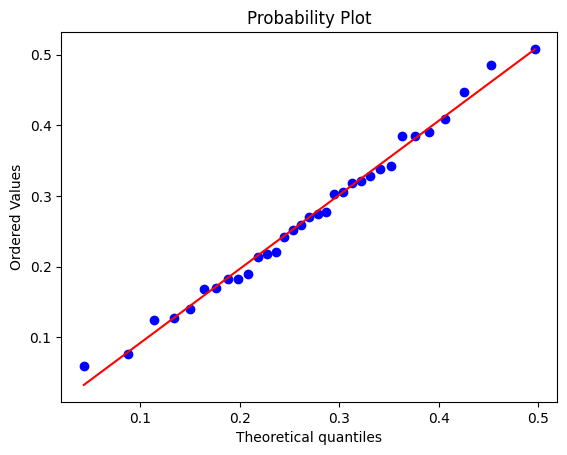

In [53]:
data = applied['ratio'].dropna()
params = stats.norm.fit(data)
D, p = stats.kstest(data, 'norm', args=params)
print(f"KS statistic={D:.4f}, p={p:.4f}")
print(params)

best_fit = stats.norm(*params)
mean, var = best_fit.stats(moments='mv')
print(f"Mean: {mean}, Variance: {var}")
print(f"Std Err: {np.sqrt(var/len(data))}")
print(f"MAE: {np.mean(np.abs(data - mean))}")
result = stats.anderson(data, dist='norm')
print(result.statistic, result.critical_values)


x = np.linspace(data.min(), data.max(), 100)
pdf_fitted = stats.norm.pdf(x, *params)

stats.probplot(data, dist=stats.norm, sparams=params, plot=plt)
plt.show()

1990
Diversion estimate: 52674 acre-ft
Error 38.52% = 20289 acre-ft
CI: 25698 to 89504
Minersville discharge: 12696 acre-ft ± 1270 acre-ft
Irrigation pumping estimate: 44981 acre-ft
USGS estimate: 41000 acre-ft
Error 41.67% = 18744 acre-ft
CI: 20635 to 79194
0.4166977264537942
1991
Diversion estimate: 51800 acre-ft
Error 38.52% = 19953 acre-ft
CI: 25271 to 88018
Minersville discharge: 14183 acre-ft ± 1418 acre-ft
Irrigation pumping estimate: 42621 acre-ft
USGS estimate: 47500 acre-ft
Error 42.77% = 18229 acre-ft
CI: 19030 to 75915
0.42769912060713444
1992
Diversion estimate: 55047 acre-ft
Error 38.52% = 21204 acre-ft
CI: 26855 to 93537
Minersville discharge: 14764 acre-ft ± 1476 acre-ft
Irrigation pumping estimate: 45289 acre-ft
USGS estimate: 35400 acre-ft
Error 42.87% = 19416 acre-ft
CI: 20154 to 80733
0.4287144776994589
1993
Diversion estimate: 60425 acre-ft
Error 38.52% = 23275 acre-ft
CI: 29479 to 102675
Minersville discharge: 27331 acre-ft ± 2733 acre-ft
Irrigation pumping estima

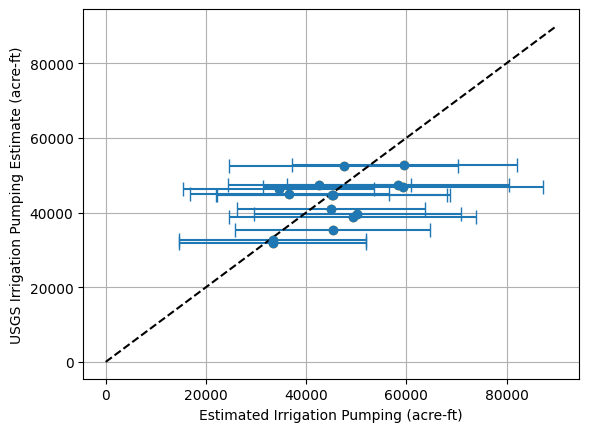

In [ ]:
# Randomly sample 10000 infiltration percentage values (with replacement is implicit)
data = applied['ratio'].dropna()
params = stats.norm.fit(data)
samples = stats.norm.rvs(*params, size=10000, random_state=42)
infil_dist = stats.norm(*params)

yrly_data = {}
yrs = [1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2020,2021,2022,2023,2024]
for year in yrs:
    print(f"{year}")

    # Now model OET consumption uncertainty as normal with MAE = 17% of consumption based on Volk et al. Uncertainty of 17%
    mae = np.sum(fields[year])*0.17
    sigma = mae * np.sqrt(np.pi / 2)
    oet_dist = stats.norm(loc=np.sum(fields[year]), scale=sigma)

    # Now combine the two distributions to estimate diversion uncertainty
    divers_samples = oet_dist.rvs(size=10000,random_state=42)/(1-infil_dist.rvs(size=10000, random_state=42)) 
    divers_params = stats.norm.fit(divers_samples)
    print(f"Diversion estimate: {np.mean(divers_samples):.0f} acre-ft")
    print(f"Error {np.std(divers_samples)/np.mean(divers_samples)*100:.2f}% = {np.mean(divers_samples)*np.std(divers_samples)/np.mean(divers_samples):.0f} acre-ft")
    print(f"CI: {np.percentile(divers_samples, 5):.0f} to {np.percentile(divers_samples, 95):.0f}")

    mae_minersville = beav.loc[year,'beaver_acft']*0.10
    sigma_minersville = mae_minersville * np.sqrt(np.pi / 2)
    print(f"Minersville discharge: {beav.loc[year,'beaver_acft']:.0f} acre-ft ± {mae_minersville:.0f} acre-ft")
    minersville_dist = stats.norm(loc=beav.loc[year,'beaver_acft'], scale=sigma_minersville)
    beav_q_samples = minersville_dist.rvs(size=10000,random_state=42) - 5000 # subtract seepage loss
    irr_pumping_samples = divers_samples - np.where(beav_q_samples<15000,beav_q_samples,15000)
    irr_pumping_params = stats.norm.fit(irr_pumping_samples)
    print(f"Irrigation pumping estimate: {np.mean(irr_pumping_samples):.0f} acre-ft")
    if year<2024:
        print(f"USGS estimate: {usgs_irr[year]:.0f} acre-ft")
    print(f"Error {np.std(irr_pumping_samples)/np.mean(irr_pumping_samples)*100:.2f}% = {np.mean(irr_pumping_samples)*np.std(irr_pumping_samples)/np.mean(irr_pumping_samples):.0f} acre-ft")
    print(f"CI: {np.percentile(irr_pumping_samples, 5):.0f} to {np.percentile(irr_pumping_samples, 95):.0f}")
    print(np.std(irr_pumping_samples)/np.mean(irr_pumping_samples))

    yrly_data[year] = pd.Series({
        'diversion_mean': np.mean(divers_samples),
        'diversion_std': np.std(divers_samples),
        'irr_pumping_mean': np.mean(irr_pumping_samples),
        'irr_pumping_std': np.std(irr_pumping_samples),
        'USGS_irr': usgs_irr.get(year, np.nan),
        'Minersville_discharge': beav.loc[year,'beaver_acft']
        })

yrly_df = pd.DataFrame(yrly_data).T
yrly_df.round(0)


pumpest = yrly_df[['irr_pumping_mean','USGS_irr']].dropna()

slope, intercept, r_value, p_value, std_err = stats.linregress(pumpest['irr_pumping_mean'], 
                                                               pumpest['USGS_irr'])

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard Error: {std_err}")
print(np.round((pumpest['irr_pumping_mean']-pumpest['USGS_irr']).abs().mean(),0))

plt.plot(yrly_df['irr_pumping_mean'], yrly_df['USGS_irr'], 'o',color='orange')
plt.errorbar(yrly_df['irr_pumping_mean'], yrly_df['USGS_irr'],
             xerr=yrly_df['irr_pumping_std'], fmt='o', capsize=5)
plt.xlabel("Estimated Irrigation Pumping (acre-ft)")
plt.ylabel("USGS Irrigation Pumping Estimate (acre-ft)")
plt.plot([0,90000],[0,90000],'k--')
plt.grid()
#plt.xlim(0,60000)

<Axes: >

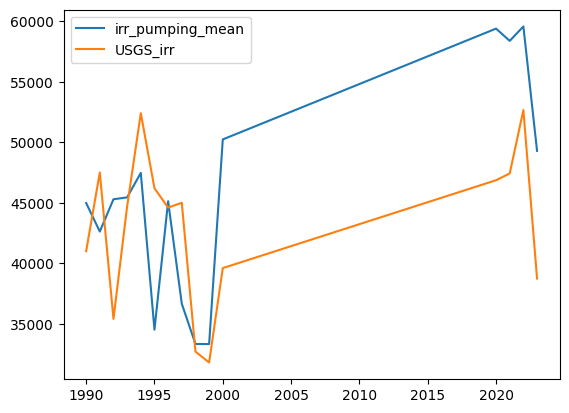

In [61]:
pumpest.plot()

1994
Diversion estimate: 74128 acre-ft
Error 33.52% = 24847 acre-ft
CI: 38829 to 118708
Minersville discharge: 20607 acre-ft ± 2061 acre-ft
Irrigation pumping estimate: 53527 acre-ft
USGS estimate: 52400 acre-ft
Error 41.66% = 22300 acre-ft
CI: 22496 to 93858
0.41661897047356344
1995
Diversion estimate: 53157 acre-ft
Error 33.52% = 17818 acre-ft
CI: 27844 to 85126
Minersville discharge: 41321 acre-ft ± 4132 acre-ft
Irrigation pumping estimate: 23185 acre-ft
USGS estimate: 46200 acre-ft
Error 76.61% = 17762 acre-ft
CI: -2156 to 55126
0.7661006526635399
1996
Diversion estimate: 72250 acre-ft
Error 33.52% = 24218 acre-ft
CI: 37845 to 115701
Minersville discharge: 26483 acre-ft ± 2648 acre-ft
Irrigation pumping estimate: 46024 acre-ft
USGS estimate: 44600 acre-ft
Error 46.82% = 21548 acre-ft
CI: 16855 to 85701
0.4681896489377288
1997
Diversion estimate: 63892 acre-ft
Error 33.52% = 21416 acre-ft
CI: 33467 to 102316
Minersville discharge: 26743 acre-ft ± 2674 acre-ft
Irrigation pumping esti

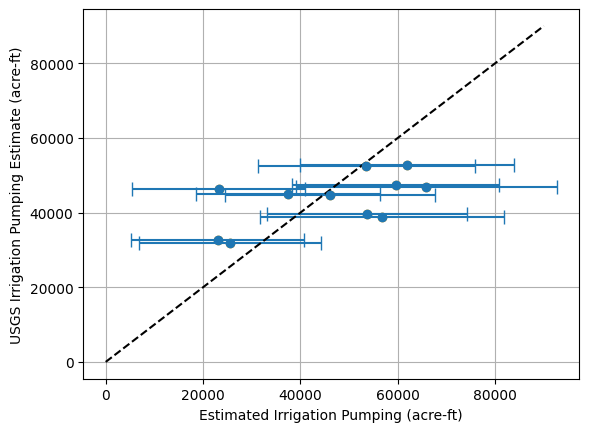

In [16]:
# Randomly sample 10000 infiltration percentage values (with replacement is implicit)
data = applied['ratio'].dropna()
params = stats.norm.fit(data)
samples = stats.norm.rvs(*params, size=10000, random_state=42)
infil_dist = stats.norm(*params)

yrly_data = {}
yrs = [1994,1995,1996,1997,1998,1999,2000,2020,2021,2022,2023,2024]
for year in yrs:
    print(f"{year}")

    # Now model OET consumption uncertainty as normal with MAE = 17% of consumption based on Volk et al. Uncertainty of 17%
    mae = applied.loc[year,"whole_raster_consumed"]*0.17
    sigma = mae * np.sqrt(np.pi / 2)
    oet_dist = stats.norm(loc=applied.loc[year,"whole_raster_consumed"], scale=sigma)

    # Now combine the two distributions to estimate diversion uncertainty
    divers_samples = oet_dist.rvs(size=10000,random_state=42)/(1-infil_dist.rvs(size=10000, random_state=42)) 
    divers_params = stats.norm.fit(divers_samples)
    print(f"Diversion estimate: {np.mean(divers_samples):.0f} acre-ft")
    print(f"Error {np.std(divers_samples)/np.mean(divers_samples)*100:.2f}% = {np.mean(divers_samples)*np.std(divers_samples)/np.mean(divers_samples):.0f} acre-ft")
    print(f"CI: {np.percentile(divers_samples, 5):.0f} to {np.percentile(divers_samples, 95):.0f}")

    mae_minersville = beav.loc[year,'discharge_acre_ft']*0.10
    sigma_minersville = mae_minersville * np.sqrt(np.pi / 2)
    print(f"Minersville discharge: {beav.loc[year,'discharge_acre_ft']:.0f} acre-ft ± {mae_minersville:.0f} acre-ft")
    minersville_dist = stats.norm(loc=beav.loc[year,'discharge_acre_ft'], scale=sigma_minersville)
    beav_q_samples = minersville_dist.rvs(size=10000,random_state=42)
    irr_pumping_samples = divers_samples - np.where(beav_q_samples<30000,beav_q_samples,30000)
    irr_pumping_params = stats.norm.fit(irr_pumping_samples)
    print(f"Irrigation pumping estimate: {np.mean(irr_pumping_samples):.0f} acre-ft")
    if year<2024:
        print(f"USGS estimate: {usgs_irr[year]:.0f} acre-ft")
    print(f"Error {np.std(irr_pumping_samples)/np.mean(irr_pumping_samples)*100:.2f}% = {np.mean(irr_pumping_samples)*np.std(irr_pumping_samples)/np.mean(irr_pumping_samples):.0f} acre-ft")
    print(f"CI: {np.percentile(irr_pumping_samples, 5):.0f} to {np.percentile(irr_pumping_samples, 95):.0f}")
    print(np.std(irr_pumping_samples)/np.mean(irr_pumping_samples))

    yrly_data[year] = pd.Series({
        'diversion_mean': np.mean(divers_samples),
        'diversion_std': np.std(divers_samples),
        'irr_pumping_mean': np.mean(irr_pumping_samples),
        'irr_pumping_std': np.std(irr_pumping_samples),
        'USGS_irr': usgs_irr.get(year, np.nan),
        'Minersville_discharge': beav.loc[year,'discharge_acre_ft']
        })

yrly_df = pd.DataFrame(yrly_data).T
yrly_df.round(0)



plt.plot(yrly_df['irr_pumping_mean'], yrly_df['USGS_irr'], 'o',color='orange')
plt.errorbar(yrly_df['irr_pumping_mean'], yrly_df['USGS_irr'],
             xerr=yrly_df['irr_pumping_std'], fmt='o', capsize=5)
plt.xlabel("Estimated Irrigation Pumping (acre-ft)")
plt.ylabel("USGS Irrigation Pumping Estimate (acre-ft)")
plt.plot([0,90000],[0,90000],'k--')
plt.grid()
#plt.xlim(0,60000)

## Methodology and Data Sources

We used two datasets to estimate each well’s annual pumping volume for 2024 and 2025:

* Field requirements: The fields_by_groupnumb.csv file lists each irrigation group (fields served together) with its area (acres), crop type, and estimated net water requirement (efet_YYYY) in acre-feet for each year. For example, group 600023 (362.62 acres of corn) required about 977.8 ac-ft in 2024 and 380.8 ac-ft in 2025. These volumes represent net irrigation needs (accounting for precipitation), so a fallow field can even show near-zero or negative values (meaning no irrigation needed).

* Well info: The wells_w_efet.csv file lists wells by Well Identification Number (WIN) and group, including pump capacity in GPM (gallons per minute) or horsepower if available. Many wells have a rated capacity (e.g. well 35682 in group 600023 is 746 GPM, while well 435545 in the same group is 1044 GPM). Where GPM was missing, we used horsepower (assuming roughly ~8 GPM per HP as a typical pump efficiency) to estimate capacity. If a well lacked both, we assumed a minimal capacity (effectively a negligible share).

Allocation approach: For each group, we first determined the total water pumped from wells by that group each year:

* If the water source is groundwater (GW), we assumed the full net requirement (efet) was supplied by the wells. For example, group 600001 (64.34 acres corn, GW) needed 189.3 ac-ft in 2024 and 65.5 ac-ft in 2025, which we assign entirely to its well.

* If the source is mixed (Mix) – meaning the fields use both groundwater and surface water – we applied the user’s assumption that groundwater wells operated only part of the season. Specifically, we assumed 170 days of pumping in 2024 (approximately a full irrigation season) but only 50 days in 2025, due to increased surface water usage in 2025. This equates to wells providing roughly 93% of the 2024 requirement and only 29% of the 2025 requirement for those fields. In practice, this drastically reduces 2025 pumping for mixed-source groups. For example, group 629454 (1369.77 acres corn, mixed source) had a total water demand of ~4389.5 ac-ft in 2024 and 1521.4 ac-ft in 2025. We estimate the wells in that group supplied nearly all of the 4389.5 ac-ft in 2024, but only about a third of that in 2025 (the rest coming from surface water).

* If the source is surface water (SW) or the field is fallow, we assumed no groundwater pumping from wells (pumping volume set to 0). For instance, group 628789 was fallow and shows essentially no irrigation requirement by 2025, so its well 999905 is assigned 0 ac-ft for both years.



After determining a group’s total pumped volume per year, we distributed that volume among the group’s wells in proportion to each well’s capacity. Higher-capacity wells are assumed to pump more of the total. For example, in group 600023 (corn) mentioned above, well 435545 (1044 GPM) is roughly 40% larger than well 35682 (746 GPM). Accordingly, out of ~977.8 ac-ft in 2024, we estimate well 435545 pumped ~570 ac-ft while well 35682 pumped ~407 ac-ft (and a very small older well 19454 with no data contributed only ~0.5 ac-ft). This proportional allocation was repeated for every group using either GPM or estimated GPM (from horsepower). Wells with negligible capacity relative to others in the same group end up with very little assigned pumping (often <1 ac-ft/year).



# Per-Well Pumping Volume Estimates (2024 & 2025)



The table below presents the estimated pumping volume for each well (by WIN) for the years 2024 and 2025. Wells are grouped by their irrigation group number for clarity. All volumes are in acre-feet per year. (Wells in mixed-source groups show a large drop in 2025 due to the reduced pumping assumption, as explained above.)

NameError: name 'gpd' is not defined

In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np

fields = gpd.read_file("gis_files/pou_oet_consumed_1991_2025.gpkg")
fields = fields.rename(columns=lambda x: int(x.replace("consumed_", "")) if "consumed_" in x else x)
print(fields.columns)

usgs_irr = {1994: 52400,
            1995: 46200,
            1996: 44600,
            1997: 45000,
            1998: 32700,
            1999: 31800,
            2000: 39600,
            2001: 33500,
            2002: 42500,
            2003: 40300,
            2004: 35800,
            2005: 31400,
            2006: 36400,
            2007: 40600,
            2008: 40300,
            2009: 45600,
            2010: 41100,
            2011: 32200,
            2012: 44700,
            2013: 45900,
            2014: 45700,
            2015: 44900,
            2016: 45000,
            2017: 46800,
            2018: 59584,
            2019: 39912,
            2020: 46863,
            2021: 47423,
            2022: 52662,
            2023: 38735,
            }

app = pd.read_csv("G:/My Drive/Milford_OpenET/applied_water_out/masked_et_pr_applied_acrefeet_summary.csv")
app['month'] = pd.to_datetime(app['month'])
app.set_index('month', inplace=True)
app = app[app.index.month.isin([4,5,6,7,8,9,10])]
appyr = app.groupby(app.index.year).sum()
appyrdict = appyr['applied_acre_feet_masked'].to_dict()

applied = fields.groupby(['WaterSourc'])[list(range(1994,2026))].sum().T
applied['GW + Mixed']= applied['GW'] + applied['Mix']
applied['usgs'] = applied.index.map(lambda x: usgs_irr.get(x))

applied['infiltration'] = applied['usgs'] - applied['GW + Mixed']
applied['ratio'] = np.where(applied['infiltration'] / applied['usgs'] > 0.05, applied['infiltration'] / applied['usgs'], np.nan)
applied['whole_raster_consumed'] = applied.index.map(lambda x: appyrdict.get(x))
applied.round(2)


Index(['GROUP_NUMB',        'URL',      'ACRES',     'WRNUMS',      'dbURL',
         'recordID',    'FieldNo', 'WaterSourc',   'FARMNAME',     'qtywtr',
            'accID',    'Acnt_no',   'field_id', 'field_id_L', 'Shape_Leng',
       'Shape_Area',   'match_id',         1994,         1995,         1996,
               1997,         1998,         1999,         2000,         2001,
               2002,         2003,         2004,         2005,         2006,
               2007,         2008,         2009,         2010,         2011,
               2012,         2013,         2014,         2015,         2016,
               2017,         2018,         2019,         2020,         2021,
               2022,         2023,         2024,         2025,   'geometry'],
      dtype='object')


WaterSourc,GW,Mix,SW,GW + Mixed,usgs,infiltration,ratio,whole_raster_consumed
1994,28486.5,7399.3,5943.5,35885.8,52400.0,16514.2,0.32,55485.42
1995,22386.2,6060.5,5158.9,28446.7,46200.0,17753.3,0.38,39788.69
1996,26925.9,7408.3,6306.8,34334.2,44600.0,10265.8,0.23,54080.04
1997,22811.5,6666.3,5508.8,29477.8,45000.0,15522.2,0.34,47823.63
1998,21277.6,6376.3,5073.8,27653.9,32700.0,5046.1,0.15,39694.65
1999,21279.2,6285.8,5099.2,27565.0,31800.0,4235.0,0.13,41561.33
2000,25949.1,7215.8,5670.2,33164.9,39600.0,6435.1,0.16,49350.03
2001,28254.7,7737.3,5820.6,35992.0,33500.0,-2492.0,NaN,55211.47
2002,25822.3,6942.9,5240.4,32765.2,42500.0,9734.8,0.23,48795.29
2003,26339.3,6965.3,5085.9,33304.6,40300.0,6995.4,0.17,50567.34


In [5]:
res_q = pd.read_csv("output_tables/res_discharge.csv")
res_q['Date'] = pd.to_datetime(res_q['Date'])
res_q.set_index('Date', inplace=True)
res_q['discharge_acre_ft'] = res_q['Flume Discharge (cfs)']*1.98347 # convert cfs to acre-ft/day
res_q = res_q.resample('D').asfreq().interpolate() # daily frequency with interpolation for data gaps
res_q_monthly = res_q.resample('ME').sum()
res_q_yearly = res_q.resample('YE').sum()
res_q_yearly['year'] = res_q_yearly.index.year
res_q_yearly.set_index('year', inplace=True)
res_q_yearly

beav_q= pd.read_csv("output_tables/beaver_at_rocky_ford_dam.txt",parse_dates={'Date':[0,1,2]},index_col='Date')
beav_q['discharge_acre_ft'] = beav_q['Discharge in CFS']*1.98347
beav_q = beav_q.resample('D').asfreq().interpolate()
beav_q_yearly = beav_q.resample('YE').sum()
beav_q_yearly['year'] = beav_q_yearly.index.year
beav_q_yearly.set_index('year', inplace=True)
beav_q_yearly = beav_q_yearly.drop(columns=['Discharge in CFS'],axis=1).round(0)
beav = pd.concat([beav_q_yearly, res_q_yearly], axis=0).drop(['Flume Discharge (cfs)', 'Notes'],axis=1).dropna().round(0)#.to_frame()




C:\Users\paulinkenbrandt\AppData\Local\Temp\1\ipykernel_20380\4054277918.py:12: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  beav_q= pd.read_csv("output_tables/beaver_at_rocky_ford_dam.txt",parse_dates={'Date':[0,1,2]},index_col='Date')


<Axes: title={'center': 'Minersville Reservoir Discharge at Rocky Ford Dam'}, xlabel='year'>

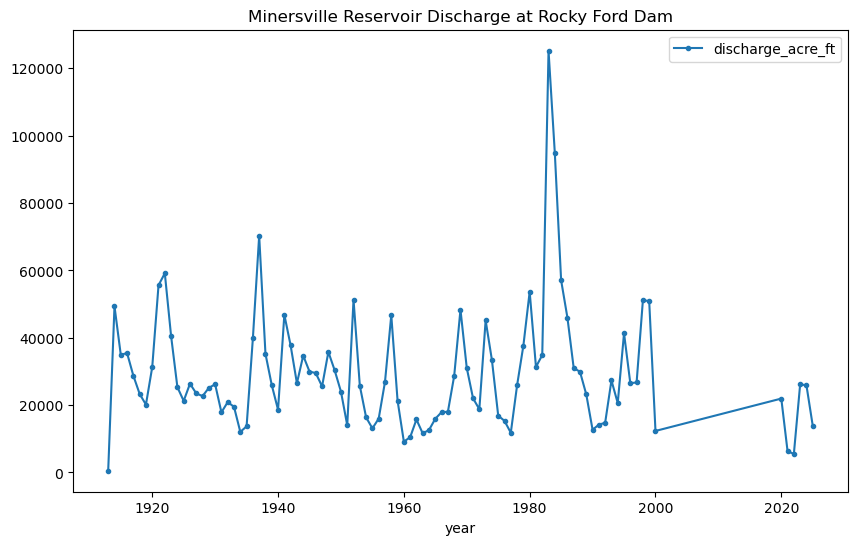

In [6]:
beav.plot(y='discharge_acre_ft', figsize=(10,6), title="Minersville Reservoir Discharge at Rocky Ford Dam", marker='.')

KS statistic=0.1156, p=0.8234
(np.float64(0.22247256775814195), np.float64(0.08919553860842075))
Mean: 0.22247256775814195, Variance: 0.007955844107646276
Std Err: 0.017165689408695124
MAE: 0.07517379946665895
0.32709303429068726 [0.517 0.589 0.707 0.824 0.98 ]


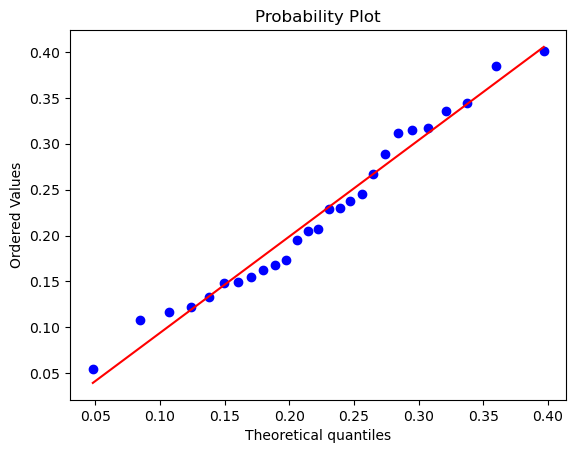

In [7]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

data = applied['ratio'].dropna()
params = stats.norm.fit(data)
D, p = stats.kstest(data, 'norm', args=params)
print(f"KS statistic={D:.4f}, p={p:.4f}")
print(params)

best_fit = stats.norm(*params)
mean, var = best_fit.stats(moments='mv')
print(f"Mean: {mean}, Variance: {var}")
print(f"Std Err: {np.sqrt(var/len(data))}")
print(f"MAE: {np.mean(np.abs(data - mean))}")
result = stats.anderson(data, dist='norm')
print(result.statistic, result.critical_values)



x = np.linspace(data.min(), data.max(), 100)
pdf_fitted = stats.norm.pdf(x, *params)

stats.probplot(data, dist=stats.norm, sparams=params, plot=plt)
plt.show()

1994
Diversion estimate: 55884 acre-ft
Error 33.52% = 18732 acre-ft
CI: 29272 to 89491
Minersville discharge: 20607 acre-ft ± 2061 acre-ft
Irrigation pumping estimate: 40898 acre-ft
USGS estimate: 52400 acre-ft
Error 45.73% = 18702 acre-ft
CI: 14272 to 74491
0.45729055137971175
1995
Diversion estimate: 44897 acre-ft
Error 33.52% = 15049 acre-ft
CI: 23517 to 71897
Minersville discharge: 41321 acre-ft ± 4132 acre-ft
Irrigation pumping estimate: 29897 acre-ft
USGS estimate: 46200 acre-ft
Error 50.34% = 15049 acre-ft
CI: 8517 to 56897
0.5033743772510282
1996
Diversion estimate: 54296 acre-ft
Error 33.52% = 18200 acre-ft
CI: 28441 to 86949
Minersville discharge: 26483 acre-ft ± 2648 acre-ft
Irrigation pumping estimate: 39296 acre-ft
USGS estimate: 44600 acre-ft
Error 46.31% = 18199 acre-ft
CI: 13441 to 71949
0.46311689262839806
1997
Diversion estimate: 46742 acre-ft
Error 33.52% = 15668 acre-ft
CI: 24484 to 74852
Minersville discharge: 26743 acre-ft ± 2674 acre-ft
Irrigation pumping estimat

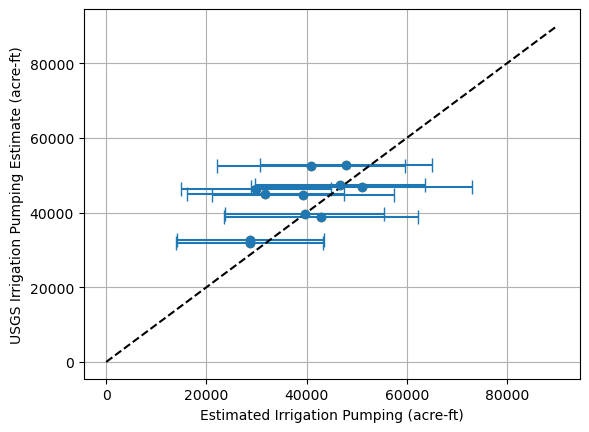

In [17]:
# Randomly sample 10000 infiltration percentage values (with replacement is implicit)
data = applied['ratio'].dropna()
params = stats.norm.fit(data)
samples = stats.norm.rvs(*params, size=10000, random_state=42)
infil_dist = stats.norm(*params)

yrly_data = {}
yrs = [1994,1995,1996,1997,1998,1999,2000,2020,2021,2022,2023,2024]
for year in yrs:
    print(f"{year}")

    # Now model OET consumption uncertainty as normal with MAE = 17% of consumption based on Volk et al. Uncertainty of 17%
    mae = np.sum(fields[year])*0.17
    sigma = mae * np.sqrt(np.pi / 2)
    oet_dist = stats.norm(loc=np.sum(fields[year]), scale=sigma)

    # Now combine the two distributions to estimate diversion uncertainty
    divers_samples = oet_dist.rvs(size=10000,random_state=42)/(1-infil_dist.rvs(size=10000, random_state=42)) 
    divers_params = stats.norm.fit(divers_samples)
    print(f"Diversion estimate: {np.mean(divers_samples):.0f} acre-ft")
    print(f"Error {np.std(divers_samples)/np.mean(divers_samples)*100:.2f}% = {np.mean(divers_samples)*np.std(divers_samples)/np.mean(divers_samples):.0f} acre-ft")
    print(f"CI: {np.percentile(divers_samples, 5):.0f} to {np.percentile(divers_samples, 95):.0f}")

    mae_minersville = beav.loc[year,'discharge_acre_ft']*0.10
    sigma_minersville = mae_minersville * np.sqrt(np.pi / 2)
    print(f"Minersville discharge: {beav.loc[year,'discharge_acre_ft']:.0f} acre-ft ± {mae_minersville:.0f} acre-ft")
    minersville_dist = stats.norm(loc=beav.loc[year,'discharge_acre_ft'], scale=sigma_minersville)
    beav_q_samples = minersville_dist.rvs(size=10000,random_state=42)
    irr_pumping_samples = divers_samples - np.where(beav_q_samples<15000,beav_q_samples,15000)
    irr_pumping_params = stats.norm.fit(irr_pumping_samples)
    print(f"Irrigation pumping estimate: {np.mean(irr_pumping_samples):.0f} acre-ft")
    if year<2024:
        print(f"USGS estimate: {usgs_irr[year]:.0f} acre-ft")
    print(f"Error {np.std(irr_pumping_samples)/np.mean(irr_pumping_samples)*100:.2f}% = {np.mean(irr_pumping_samples)*np.std(irr_pumping_samples)/np.mean(irr_pumping_samples):.0f} acre-ft")
    print(f"CI: {np.percentile(irr_pumping_samples, 5):.0f} to {np.percentile(irr_pumping_samples, 95):.0f}")
    print(np.std(irr_pumping_samples)/np.mean(irr_pumping_samples))

    yrly_data[year] = pd.Series({
        'diversion_mean': np.mean(divers_samples),
        'diversion_std': np.std(divers_samples),
        'irr_pumping_mean': np.mean(irr_pumping_samples),
        'irr_pumping_std': np.std(irr_pumping_samples),
        'USGS_irr': usgs_irr.get(year, np.nan),
        'Minersville_discharge': beav.loc[year,'discharge_acre_ft']
        })

yrly_df = pd.DataFrame(yrly_data).T
yrly_df.round(0)



plt.plot(yrly_df['irr_pumping_mean'], yrly_df['USGS_irr'], 'o',color='orange')
plt.errorbar(yrly_df['irr_pumping_mean'], yrly_df['USGS_irr'],
             xerr=yrly_df['irr_pumping_std'], fmt='o', capsize=5)
plt.xlabel("Estimated Irrigation Pumping (acre-ft)")
plt.ylabel("USGS Irrigation Pumping Estimate (acre-ft)")
plt.plot([0,90000],[0,90000],'k--')
plt.grid()
#plt.xlim(0,60000)

In [ ]:
plt.hist(divers_samples, bins=30, density=True, alpha=0.5, label='Estimated Diversion with OET uncertainty')
x = np.linspace(divers_samples.min(), divers_samples.max(), 10000)
pdf_fitted = stats.norm.pdf(x, *divers_params)
plt.plot(x, pdf_fitted, 'r-', label='Normal fit')
plt.legend()
plt.show()

plt.hist(irr_pumping_samples, bins=30, density=True, alpha=0.5, label='Estimated Irrigation Pumping with OET uncertainty')
x = np.linspace(irr_pumping_samples.min(), irr_pumping_samples.max(), 10000)
pdf_fitted = stats.norm.pdf(x, *irr_pumping_params)
plt.plot(x, pdf_fitted, 'r-', label='Normal fit')
plt.legend()


KeyError: 2024

0.3461517635753352
[30897.238599   97352.99497483]
57429.95651421992 59965.31649272657 20757.100057310436


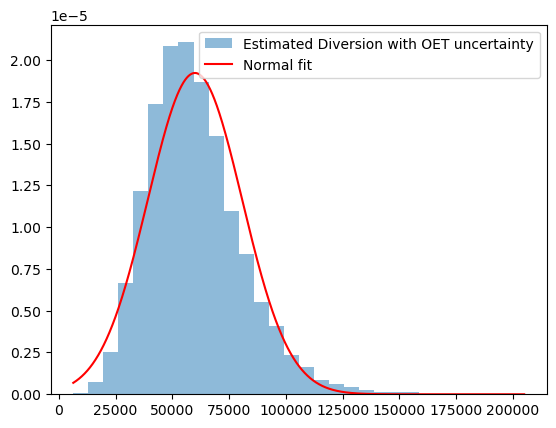

In [ ]:
mae = np.sum(fields[2024])*0.17
sigma = mae * np.sqrt(np.pi / 2)
oet_dist = stats.norm(loc=np.sum(fields[2024]), scale=sigma)

divers_samples = oet_dist.rvs(size=10000,random_state=42)/(1-infil_dist.rvs(size=10000, random_state=42)) 

divers_params = stats.norm.fit(divers_samples)
print(np.std(divers_samples)/np.mean(divers_samples))
print(np.percentile(divers_samples, [5,95]))
print(np.median(divers_samples), np.mean(divers_samples), np.std(divers_samples))
plt.hist(divers_samples, bins=30, density=True, alpha=0.5, label='Estimated Diversion with OET uncertainty')
x = np.linspace(divers_samples.min(), divers_samples.max(), 10000)
pdf_fitted = stats.norm.pdf(x, *divers_params)
plt.plot(x, pdf_fitted, 'r-', label='Normal fit')
plt.legend()
plt.show()

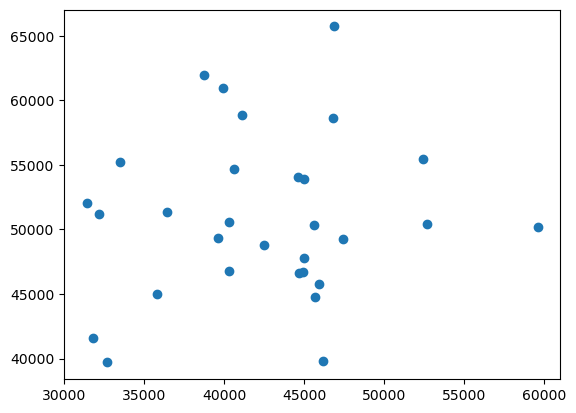

In [63]:
import matplotlib.pyplot as plt
plt.scatter(applied['usgs'],applied['whole_raster_consumed'])

In [3]:
# ---- Paths (adjust if needed) ----
WELLS_PATH = Path("output_tables/wells_with_properties.csv")
FIELDS_PATH = Path("output_tables/fields_by_groupnumber_v2.csv")
OUT_PATH   = Path("output_tables/well_pump_est.csv")

# ---- Configuration ----
YEARS = [2021,2022,2023,2024]
CANAL_DAYS_BY_YEAR = {2021:0, 2022:10, 2023:180, 2024: 180}   # your assumption
GPM_PER_HP_DEFAULT = 8.0                     # fallback if GPM missing
TOTALIZER_MIN_AF   = 1.0                     # treat Totalizer as annual anchor if in this range
TOTALIZER_MAX_AF   = 3000.0

# Deterministic per-well pumping estimator (AF) for 2024 & 2025
# ---- Load ----
wells  = pd.read_csv(WELLS_PATH)
#fields = pd.read_csv(FIELDS_PATH)



wells.columns  = [well_pump.norm(c) for c in wells.columns]
#fields.columns = [well_pump.norm(c) for c in fields.columns]

# ---- Capacity (GPM) per well: use GPM; else HP*rule; else (optional) diameter² factor ----
diam_cols_guess = [c for c in wells.columns if 'diam' in str(c).lower() or 'casing' in str(c).lower()]
diam_col = diam_cols_guess[0] if diam_cols_guess else None


k_diam = well_pump.derive_k_diam(wells, diam_col) if diam_col else None

wells["alloc_capacity_gpm"] = wells.apply(well_pump.compute_capacity_gpm, axis=1)


fld = pd.read_csv(FIELDS_PATH)

for y in YEARS:
    gwf = fld.apply(lambda r: well_pump.gw_fraction(r, y), axis=1)
    fld[f"group_AF_gw_{y}"] = (pd.to_numeric(fld[f"efet_{y}"], errors="coerce") * gwf).clip(lower=0.0)

group_totals = fld.set_index("GROUP_NUMB")[["WaterSourc","watering_days"] + [f"group_AF_gw_{y}" for y in YEARS]]
w = wells.merge(group_totals, on="GROUP_NUMB", how="left")


# ---- Build per-well rows (positional index per group avoids label collisions) ----
rows = []
for y in YEARS:
    gcol = f"group_AF_gw_{y}"
    for group_id, sub in w.groupby("GROUP_NUMB", as_index=False):
        group_total = sub[gcol].iloc[0] if gcol in sub.columns else np.nan
        sub_pos = sub.reset_index(drop=True)
        perwell = well_pump.allocate_group_to_wells(sub_pos, group_total)
        for i, af in enumerate(perwell):
            row = sub_pos.iloc[i]
            rows.append({
                "year": y,
                "GROUP_NUMB": group_id,
                "WIN": row.get("WIN"),
                "WaterSourc": row.get("WaterSourc"),
                "watering_days": row.get("watering_days"),
                "GPM": row.get("GPM"),
                "Horsepower": row.get("Horsepower"),
                "Totalizer": row.get("Totalizer"),
                "alloc_capacity_gpm": row.get("alloc_capacity_gpm"),
                "group_AF_from_wells": group_total,
                "AF_per_well_estimated": float(af),
            })

alloc_df = pd.DataFrame(rows)
alloc_df.to_csv(OUT_PATH, index=False)
print("Wrote:", OUT_PATH)

# ---- Quick QA ----
print("\nSummary by year (total AF from wells):")
print(alloc_df.groupby('year')["AF_per_well_estimated"].sum().round(1))

check = alloc_df.groupby(["year","GROUP_NUMB"]).agg(
    group_level=("group_AF_from_wells","first"),
    sum_of_wells=("AF_per_well_estimated","sum"),
)
check["diff"] = (check["sum_of_wells"] - check["group_level"]).round(6)
print("\nAllocation check (should be ~0 diffs):")
print(check[np.abs(check["diff"]) > 1e-6].head(10))


Wrote: output_tables\well_pump_est.csv

Summary by year (total AF from wells):
year
2021    31974.9
2022    32134.4
2023    34271.0
2024    26215.8
Name: AF_per_well_estimated, dtype: float64

Allocation check (should be ~0 diffs):
Empty DataFrame
Columns: [group_level, sum_of_wells, diff]
Index: []


In [ ]:
!pip install "pymc>=5" arviz pandas numpy
!python /mnt/data/bayes_pumping_model_pymc.py --draws 1500 --tune 1000 --target_accept 0.9


In [ ]:
"""
bayes_pumping_model_pymc.py
------------------------------------------
Bayesian model for per-well annual pumping (acre-feet) with uncertainty.

Data inputs:
  - wells_w_efet.csv       (well-level attributes: GPM, HP, Diameter?, Totalizer, Total_kWh, GROUP_NUMB)
  - fields_by_groupnumb.csv (field-level: efet_2024/2025, WaterSourc, watering_days, ACRES)

Outputs (written to ./bayes_outputs/):
  - posterior_AF_per_well_year.csv
  - posterior_weights_per_well_year.csv
  - idata.nc  (full PyMC InferenceData)

Run example:
  pip install pymc arviz pandas numpy
  python bayes_pumping_model_pymc.py --draws 1500 --tune 1000 --target_accept 0.9
"""

import argparse
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import aesara.tensor as at
from pathlib import Path

# ------------------------------------------------
# CLI arguments
# ------------------------------------------------

parser = argparse.ArgumentParser()
parser.add_argument("--wells", default="/output_tables/wells_with_properties.csv")
parser.add_argument("--fields", default="/output_tables/fields_by_groupnumber_v2.csv")
parser.add_argument("--draws", type=int, default=1000)
parser.add_argument("--tune", type=int, default=1000)
parser.add_argument("--target_accept", type=float, default=0.9)
parser.add_argument("--seed", type=int, default=42)
parser.add_argument("--outdir", default="/output_tables/bayes_outputs")
args = parser.parse_args()

np.random.seed(args.seed)
OUTDIR = Path(args.outdir)
OUTDIR.mkdir(parents=True, exist_ok=True)

YEARS = [2024, 2025]
CANAL_DAYS_BY_YEAR = {2024: 170, 2025: 50}
TOTALIZER_MIN_AF = 1.0
TOTALIZER_MAX_AF = 5000.0

# ------------------------------------------------
# Load data
# ------------------------------------------------
def norm(s):
    return s.strip() if isinstance(s, str) else s

wells = pd.read_csv(args.wells)
fields = pd.read_csv(args.fields)
wells.columns = [norm(c) for c in wells.columns]
fields.columns = [norm(c) for c in fields.columns]

# Detect diameter column if present
diam_cols = [c for c in wells.columns if "diam" in str(c).lower()]
diam_col = diam_cols[0] if diam_cols else None

# ------------------------------------------------
# Compute group groundwater demand from field efet and Mix fraction
# ------------------------------------------------
def gw_fraction(row, year):
    ws = str(row.get("WaterSourc", "")).strip().lower()
    wd = pd.to_numeric(row.get("watering_days"), errors="coerce")
    if ws == "gw":
        return 1.0
    if ws == "mix" and pd.notna(wd) and wd > 0:
        canal_days = CANAL_DAYS_BY_YEAR.get(year, 0)
        return max(0.0, (wd - canal_days) / float(wd))
    return 1.0

agg = {"ACRES":"sum", "type":"first", "watering_days":"first", "WaterSourc":"first"}
for y in YEARS:
    agg[f"efet_{y}"] = "sum"

fld = fields.groupby("GROUP_NUMB", as_index=False).agg(agg)
for y in YEARS:
    gwf = fld.apply(lambda r: gw_fraction(r, y), axis=1)
    fld[f"group_AF_gw_{y}"] = (pd.to_numeric(fld[f"efet_{y}"], errors="coerce") * gwf).clip(lower=0.0)

# Merge totals onto wells
group_totals = fld.set_index("GROUP_NUMB")[["WaterSourc", "watering_days"] + [f"group_AF_gw_{y}" for y in YEARS]]
w = wells.merge(group_totals, on="GROUP_NUMB", how="left")

# ------------------------------------------------
# Build data arrays
# ------------------------------------------------
groups = w["GROUP_NUMB"].values
group_ids, group_index = np.unique(groups, return_inverse=True)
G = len(group_ids)
N = len(w)
Y = len(YEARS)

group_demand = np.stack([
    fld.set_index("GROUP_NUMB")[f"group_AF_gw_{y}"].reindex(group_ids).values for y in YEARS
], axis=1)  # G x Y
group_demand_by_well = group_demand[group_index, :]  # N x Y

log_gpm_obs = np.log(pd.to_numeric(w["GPM"], errors="coerce"))
hp = pd.to_numeric(w["Horsepower"], errors="coerce")
hp_log = np.log1p(hp)
diam = pd.to_numeric(w[diam_col], errors="coerce") if diam_col else None
d2_log = np.log1p(diam**2) if diam_col is not None else None
totalizer = pd.to_numeric(w["Totalizer"], errors="coerce")
is_tot_anchor = (totalizer >= TOTALIZER_MIN_AF) & (totalizer <= TOTALIZER_MAX_AF)

# ------------------------------------------------
# Build PyMC model
# ------------------------------------------------
with pm.Model() as model:
    # Log-GPM capacity model
    mu_loggpm = pm.Normal("mu_loggpm", mu=4.5, sigma=1.5)
    sigma_loggpm = pm.HalfNormal("sigma_loggpm", sigma=1.0)
    b_hp = pm.Normal("b_hp", mu=0.5, sigma=0.5)
    if d2_log is not None:
        b_d2 = pm.Normal("b_d2", mu=0.5, sigma=0.5)
        mu_i = mu_loggpm + b_hp * np.nan_to_num(hp_log, 0) + b_d2 * np.nan_to_num(d2_log, 0)
    else:
        mu_i = mu_loggpm + b_hp * np.nan_to_num(hp_log, 0)
    log_gpm_latent = pm.Normal("log_gpm_latent", mu=mu_i, sigma=sigma_loggpm, shape=N)

    # Observed GPM likelihood
    gpm_mask = np.isfinite(log_gpm_obs)
    pm.Normal("log_gpm_obs_like", mu=log_gpm_latent[gpm_mask], sigma=0.25, observed=log_gpm_obs[gpm_mask])

    # Allocation weights per group-year (logistic-normal)
    beta_cap = pm.Normal("beta_cap", mu=1.0, sigma=0.5)
    a_g_y = pm.Normal("a_g_y", mu=0.0, sigma=0.5, shape=(G, Y))
    sigma_eps = pm.HalfNormal("sigma_eps", sigma=1.0)
    eps_i_y = pm.Normal("eps_i_y", mu=0.0, sigma=sigma_eps, shape=(N, Y))

    center = pm.Deterministic("center_log_gpm", at.mean(log_gpm_latent))
    logits = a_g_y[group_index, :] + beta_cap * (log_gpm_latent[:, None] - center) + eps_i_y

    # Normalize weights within each group-year (softmax)
    exp_logits = at.exp(logits)
    weights = at.zeros_like(exp_logits)
    for yi in range(Y):
        sums = at.zeros(G)
        sum_vec = [at.sum(exp_logits[group_index == g, yi]) for g in range(G)]
        sums = at.as_tensor_variable(sum_vec)
        w_y = at.zeros(N)
        for g in range(G):
            mask = group_index == g
            w_y = at.set_subtensor(w_y[mask], exp_logits[mask, yi] / (sums[g] + 1e-9))
        weights = at.set_subtensor(weights[:, yi], w_y)

    pm.Deterministic("weights", weights)

    # Well AF = weight × group demand
    group_demand_tt = at.as_tensor_variable(group_demand_by_well)
    AF_well = pm.Deterministic("AF_well", weights * group_demand_tt)

    # Likelihood: Totalizer (log-space)
    sigma_tot = pm.HalfNormal("sigma_tot", sigma=0.5)
    if is_tot_anchor.any():
        pm.LogNormal(
            "totalizer_like",
            mu=at.log(AF_well[is_tot_anchor, 0] + 1e-6),
            sigma=sigma_tot,
            observed=totalizer[is_tot_anchor],
        )

    # Sample
    idata = pm.sample(
        draws=args.draws, tune=args.tune, chains=4,
        target_accept=args.target_accept, random_seed=args.seed
    )

    # Summaries
    af = idata.posterior["AF_well"].stack(sample=("chain","draw")).transpose("sample","dim_0","dim_1")
    af_np = af.values
    def summarize(arr):
        lo = np.percentile(arr, 5, axis=0)
        med = np.percentile(arr, 50, axis=0)
        hi = np.percentile(arr, 95, axis=0)
        return lo, med, hi
    lo, med, hi = summarize(af_np)

    rows = []
    for i in range(N):
        for yi, year in enumerate(YEARS):
            rows.append({
                "WIN": w.loc[i, "WIN"],
                "GROUP_NUMB": w.loc[i, "GROUP_NUMB"],
                "year": year,
                "AF_lo5": lo[i, yi],
                "AF_med": med[i, yi],
                "AF_hi95": hi[i, yi],
            })
    post_df = pd.DataFrame(rows)
    post_df.to_csv(OUTDIR / "posterior_AF_per_well_year.csv", index=False)

    # Also export weight summaries
    wt = idata.posterior["weights"].stack(sample=("chain","draw")).transpose("sample","dim_0","dim_1").values
    lo_w, med_w, hi_w = summarize(wt)
    rows_w = []
    for i in range(N):
        for yi, year in enumerate(YEARS):
            rows_w.append({
                "WIN": w.loc[i, "WIN"],
                "GROUP_NUMB": w.loc[i, "GROUP_NUMB"],
                "year": year,
                "w_lo5": lo_w[i, yi],
                "w_med": med_w[i, yi],
                "w_hi95": hi_w[i, yi],
            })
    post_w = pd.DataFrame(rows_w)
    post_w.to_csv(OUTDIR / "posterior_weights_per_well_year.csv", index=False)

    az.to_netcdf(idata, OUTDIR / "idata.nc")
    print(f"Saved results in {OUTDIR}")


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.


AttributeError: `np.obj2sctype` was removed in the NumPy 2.0 release. Use `np.dtype(obj).type` instead.